# Homework E. Araya: See solution at the end of notebook.

# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the digit images directly to the model.
    - The two Conv2D layers belows learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 55 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

2022-10-12 23:35:06.534848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
98/98 [==============================] - 32s 321ms/step - loss: 1.7502 - accuracy: 0.3674
Epoch 2/3
98/98 [==============================] - 33s 335ms/step - loss: 1.3787 - accuracy: 0.5052
Epoch 3/3
98/98 [==============================] - 31s 321ms/step - loss: 1.2333 - accuracy: 0.5643


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

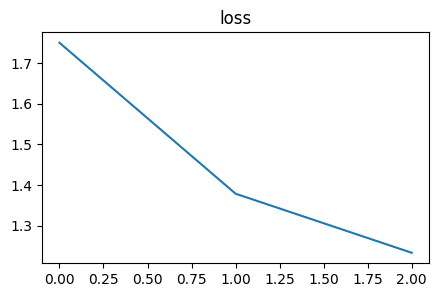

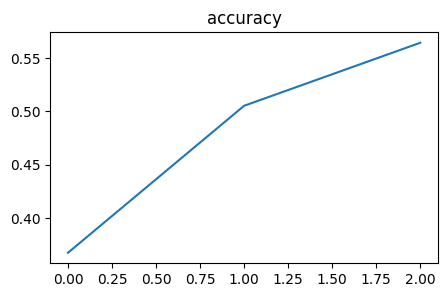

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 99%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). Even more results can be found [here](http://yann.lecun.com/exdb/mnist/).

In [7]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 3s - loss: 1.1033 - accuracy: 0.6219 - 3s/epoch - 8ms/step
accuracy: 62.19%
CPU times: user 16 s, sys: 205 ms, total: 16.2 s
Wall time: 2.68 s


We can also again check the confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 3s 8ms/step
[[723  12  68  28  14  10   5   2 107  31]
 [ 51 702  10  19   7  12   7   4  65 123]
 [ 75   6 499  96 104 112  44  29  24  11]
 [ 22   6  81 488  60 246  39  25  15  18]
 [ 42   2 146  87 510  76  49  67  15   6]
 [ 18   3  75 189  47 603  10  40   9   6]
 [  7   6  63 153  78  38 628   6  13   8]
 [ 19   0  43  59  62 133   6 643   7  28]
 [113  41  15  32   5  16   4   4 740  30]
 [ 53 109  15  41   6   9   8  14  62 683]]

Classification accuracy for each class:

0: 0.7230
1: 0.7020
2: 0.4990
3: 0.4880
4: 0.5100
5: 0.6030
6: 0.6280
7: 0.6430
8: 0.7400
9: 0.6830


### More verbose training

This approach explicitly handles the looping over data. It will be helpful this afternoon for diving in and optimizing

In [9]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [10]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [11]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [12]:
def train_network(_batch_size, _n_training_epochs, _lr):

    mnist_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, mnist_model, opt)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 30.4 seconds for epoch #0
beginning epoch 1
took 30.1 seconds for epoch #1
beginning epoch 2
took 30.3 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning weight, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

## Solution:

The following changes were made: 

`Accuracy = 56.04% In original model`

`Accuracy = 64.11% epochs = 5`

`Accuracy = 64.68% epochs = 5, lr = 0.005`

`Accuracy = 68.23% epochs = 5, lr = 0.005, batch_size = 64`

`Accuracy = 70.06% epochs = 5, lr = 0.005, batch_size = 64, self.dense_5 = tf.keras.layers.Dense(256`

`Accuracy = 71.96% epochs = 5, lr = 0.005, batch_size = 64, self.dense_5 = tf.keras.layers.Dense(256; added: self.conv_2a = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')`

`Accuracy = 73.41% epochs = 10, lr = 0.005, batch_size = 64, self.dense_5 = tf.keras.layers.Dense(256; added: self.conv_2a = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')`

`Other optimizers were tested, adam gave best results.`


In [60]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.conv_2a = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
#        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.dense_5 = tf.keras.layers.Dense(256, activation='relu') #EA
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_2a(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

## Model ran here:
batch_size = 64#512
epochs = 10
lr = .005
history, cnn_model = train_network_concise(batch_size, epochs, lr)




Epoch 1/10
782/782 [==============================] - 121s 154ms/step - loss: 1.4958 - accuracy: 0.4604
Epoch 2/10
782/782 [==============================] - 122s 157ms/step - loss: 1.1182 - accuracy: 0.6054
Epoch 3/10
782/782 [==============================] - 122s 156ms/step - loss: 0.9769 - accuracy: 0.6556
Epoch 4/10
782/782 [==============================] - 123s 157ms/step - loss: 0.8699 - accuracy: 0.6938
Epoch 5/10
782/782 [==============================] - 124s 159ms/step - loss: 0.7837 - accuracy: 0.7228
Epoch 6/10
782/782 [==============================] - 123s 157ms/step - loss: 0.7107 - accuracy: 0.7456
Epoch 7/10
782/782 [==============================] - 125s 160ms/step - loss: 0.6501 - accuracy: 0.7670
Epoch 8/10
782/782 [==============================] - 124s 158ms/step - loss: 0.5999 - accuracy: 0.7857
Epoch 9/10
782/782 [==============================] - 123s 157ms/step - loss: 0.5601 - accuracy: 0.8001
Epoch 10/10
782/782 [==============================] - 124s 158m

In [61]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 9s - loss: 0.8413 - accuracy: 0.7341 - 9s/epoch - 29ms/step
accuracy: 73.41%
CPU times: user 58.5 s, sys: 356 ms, total: 58.9 s
Wall time: 9.07 s


In [62]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 9s 28ms/step
[[828  16  33   7   9   3   7   7  56  34]
 [ 30 846   5   7   3   0   6   0  24  79]
 [ 93   5 604  44  77  52  59  33  19  14]
 [ 49  14  88 507  47 154  55  40  25  21]
 [ 56   4  74  58 660  25  40  71   8   4]
 [ 28   8  64 136  38 637  28  47   9   5]
 [ 15  12  57  48  23  18 800   6  13   8]
 [ 27   8  50  36  37  37   7 779   4  15]
 [ 67  20   8  10   5   4   3   2 853  28]
 [ 38  72  10   9   3   1   3   6  31 827]]

Classification accuracy for each class:

0: 0.8280
1: 0.8460
2: 0.6040
3: 0.5070
4: 0.6600
5: 0.6370
6: 0.8000
7: 0.7790
8: 0.8530
9: 0.8270
